## Gesture Recognition : 

### Problem Statement:-
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

- Two types of architectures are used commonly. One is the standard CNN + RNN architecture in which you pass the images of a video through a CNN which extracts a feature vector for each image, and then pass the sequence of these feature vectors through an RNN.

- The other popular architecture used to process videos is a natural extension of CNNs - a 3D convolutional network

#### Colab gdrive mount:-

In [1]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Unzip file in Colab

In [2]:
!unzip "/content/gdrive/MyDrive/ML/Project_data.zip"

Streaming output truncated to the last 5000 lines.
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00050.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: Project_data/t

## Load the required library

In [57]:
#GPU version 
#!nvidia-smi

Sat May 29 01:33:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |   4801MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
np.random.seed(40)
import random 
import datetime
from skimage.transform import resize
from skimage.io import imread

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, GRU,LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv2D,Conv3D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
import keras

## Set the data path:

In [4]:
## If run in colab--> Uncomment, These are file path from colab

csv_train_path = "/content/Project_data/train.csv"
csv_val_path = "/content/Project_data/val.csv"
src_path = "/content/Project_data"


train_path_dir = "/content/Project_data/train"   
val_path_dir = "/content/Project_data/val"

In [5]:
## File path from Desktop
# csv_train_path = "C:\\Users\\I324158\\Downloads\\Project_data\\Project_data\\train.csv"
# csv_val_path = "C:\\Users\\I324158\\Downloads\\Project_data\\Project_data\\val.csv"
# src_path = "C:\\Users\\I324158\\Downloads\\Project_data\\Project_data"

In [6]:
# train_path_dir = "C:\\Users\\I324158\\Downloads\\Project_data\\Project_data\\train"   
# val_path_dir = "C:\\Users\\I324158\\Downloads\\Project_data\\Project_data\\val"

## Load the csv files:

In [38]:
# No of entries in CSV files : Read content from csv
train_doc= np.random.permutation(open(csv_train_path).readlines())
val_doc = np.random.permutation(open(csv_val_path).readlines())
classes=5 #left swipe, right swipe, thumbs up, thumbs down, stop

### Check the data before processing:

please ignore statement:-->coming from tensorflow <---- Found 19890 files belonging to 663 classes.
Found 19890 files belonging to 663 classes.
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
----------------------------------------


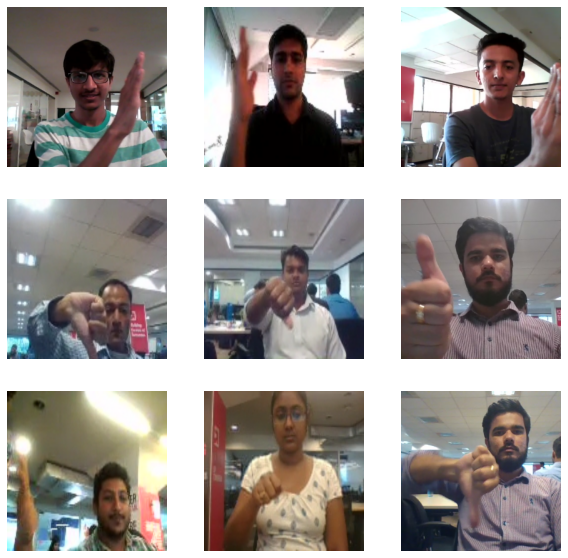

In [39]:
# Check the data
print("please ignore statement:-->coming from tensorflow <---- Found 19890 files belonging to 663 classes.")
train_data_check = tf.keras.preprocessing.image_dataset_from_directory(train_path_dir)
plt.figure(figsize=(10, 10))
for images, labels in train_data_check.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        print(images[i].numpy().shape)
        
        plt.axis("off")
        plt.xticks()
    print("----------------------------------------")
    






### Define Custom Generator function  for train and validation data 



In [40]:
x = 30 # number of frames in video
y = 120 # image width
z = 120 # image height 

# Use image normalization as img/127.5-1  instead of  img/255 
# img/255 to normalize the image, the range is [0, 1],
# img/127.5-1 to normalize the image, the range is [-1,1]



def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    temp = resize(image,(y,z))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1]) #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2]) #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(y,z))
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


In [41]:
#Check current datetime, which will be used in Model saving in callback
curr_dt_time = datetime.datetime.now()
#Training and validation data directoty
train_path = train_path_dir
val_path = val_path_dir
#check no of training data in CSV file
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


### Function to plot training and validation loss:

In [42]:
# function to Plot the training loss and validation loss, Training accuracy and Validation accuracy:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model Experiments :


## Model 1 : 3D convolution neural network 
-  Filter size (3,3,3),
- Image size (120,120),
- Usage of batchnormalization
- Usage of dropout in fully connected layer(dense)
- batch size =10,
- No of epoch =10

In [12]:
batch_size = 10 
num_epochs=10

In [13]:
model_1 = Sequential()

model_1.add(Conv3D(8, #number of filters 
                 kernel_size=(2,2,2), 
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(16, #Number of filters, 
                 kernel_size=(2,2,2), 
                 padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2,2,2)))


model_1.add(Conv3D(32, #Number of filters 
                 kernel_size=(2,2,2), 
                 padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2,2,2)))

model_1.add(Conv3D(64, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))

model_1.add(MaxPooling3D(pool_size=(2,2,2)))



#Flatten Layers
model_1.add(Flatten())


#softmax layer
model_1.add(Dense(5, activation='softmax'))


In [14]:
optimiser = optimizers.Adam() #write your optimizer
model_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy']) #Compile the model
print (model_1.summary()) #Check summary of layers in the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 120, 120, 8)   200       
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation (Activation)      (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 60, 60, 16)    1040      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_1 (Activation)    (None, 15, 60, 60, 16)    0

- Total params for this architect: Trainable params: 76,893
- Trainable params: 76,653
- Non-trainable params: 240 which are coming from maxpooling layer

## Model saving 

In [43]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/' # save the model with timestamp
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + "model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5" #file path for saving the model

#callback in keras :1.Model checkpoint 2.Reduce Learning rate on plateu
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq="epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [44]:
#Function to get the steps per epoch which depends on batch size.
#This will feed to model fir function 
def get_steps_per_epoch(batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
        print(f"Steps per Epoch on Tranining:{steps_per_epoch}")
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1
        print(f"Steps per Epoch on Tranining:{steps_per_epoch}")

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
        print(f"Steps per Epoch on Validation:{validation_steps}")
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
        print(f"Steps per Epoch on Validation:{validation_steps}")
    return [steps_per_epoch,validation_steps]


In [45]:
#create generator for training and validation 

train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

### Steps per epoch calculation for model fit method 

In [46]:
# steps_per_epoch, validation_steps=  get_steps_per_epoch(batch_size)


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
#train the model
history = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - 203s 3s/step - loss: 2.2877 - categorical_accuracy: 0.3670 - val_loss: 2.0254 - val_categorical_accuracy: 0.1900

Epoch 00001: val_loss improved from inf to 2.02540, saving model to model_init_2021-05-2900_09_07.104813/model-00001-1.61232-0.48265-2.02540-0.19000.h5
Epoch 2/10
67/67 [==============================] - 79s 1s/step - loss: 1.1282 - categorical_accuracy: 0.5531 - val_loss: 2.6469 - val_categorical_accuracy: 0.2700

Epoch 00002: val_loss did not improve from 2.02540
Epoch 3/10
67/67 [==============================] - 68s 1s/step - loss: 1.0850 - categorical_accuracy: 0.6032 - val_loss: 1.9995 - val_categorical_accuracy: 0.3400

Epoch 00003: val_loss improved from 2.02540 to 1.99952, saving model to model_init_2021-05-2900_09_07.104813/model-00003-1.00884-0.61194-1.99952-0.34000.h5
Epoch 4/10
67/67 [==============================] - 72s 1s/step - loss: 1.0376 - cat

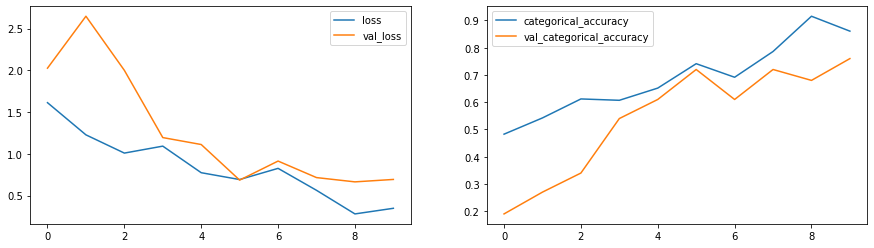

In [27]:
#check the training and validation  {loss and accuracy}
plot(history)

### Findings:
- We have used batchnormalization in convolution layer.
- Image size was takes (120,120) and 30 frames at a time.
- With epoch 10 and batch size 10, model is improving.
- From the above graph, training and validation loss looks jumpy.
- Training loss: 0.3390 
- Training accuracy: 83.44% 
- validation loss: 0.8251 
- validation accuracy: 76.0%

In [47]:
channel=3
x = 30
y = 120
z= 120

In [48]:
##An intuitive way to convert a color image 3D array to a grayscale 2D array is, 
##for each pixel, take the average of the red, green, and blue pixel values to get the grayscale value.
## This combines the lightness or luminance contributed by each color band into a reasonable gray approximation.
## This has been performed at {temp = temp.mean(axis=-1,keepdims=1)}

def modified_generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    temp = resize(image,(y,z))
                    temp = temp.mean(axis=-1,keepdims=1)  #Converting to gray scale
                    temp = temp/127.5-1 #Normalize data
                    batch_data[folder,idx] = temp #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,channel)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,classes)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = resize(image,(y,z))
                    #Converting to gray scale
                    temp = temp.mean(axis=-1,keepdims=1) 
                    temp = temp/127.5-1 #Normalize data
                    
                    batch_data[folder,idx] = temp
                   
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels



## Model 2: with changing Epoch and Batch size with Model 1 architecture


In [28]:
batch_size=20
epochs =10

In [30]:
train_generator = modified_generator(train_path,train_doc,batch_size)
val_generator = modified_generator(val_path,val_doc,batch_size)

In [ ]:
# steps_per_epoch, validation_steps=  get_steps_per_epoch(batch_size)

Steps per Epoch on Tranining:34
Steps per Epoch on Validation:5


In [31]:
history = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/10
67/67 [==============================] - 238s 4s/step - loss: 0.2789 - categorical_accuracy: 0.9121 - val_loss: 0.9646 - val_categorical_accuracy: 0.6500

Epoch 00001: val_loss did not improve from 0.57707
Epoch 2/10
67/67 [==============================] - 97s 1s/step - loss: 0.3257 - categorical_accuracy: 0.8856 - val_loss: 0.6599 - val_categorical_accuracy: 0.7750

Epoch 00002: val_loss did not improve from 0.57707
Epoch 3/10
67/67 [==============================] - 113s 2s/step - loss: 0.3733 - categorical_accuracy: 0.8607 - val_loss: 0.7179 - val_categorical_accuracy: 0.7100

Epoch 00003: val_loss did not improve from 0.57707
Epoch 4/10
67/67 [==============================] - 91s 1s/step - loss: 0.4049 - categorical_accuracy: 0.8209 - val_loss: 1.1359 - val_categorical_accuracy: 0.6400

Epoch 00004: val_loss did not improve from 0.57707

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118

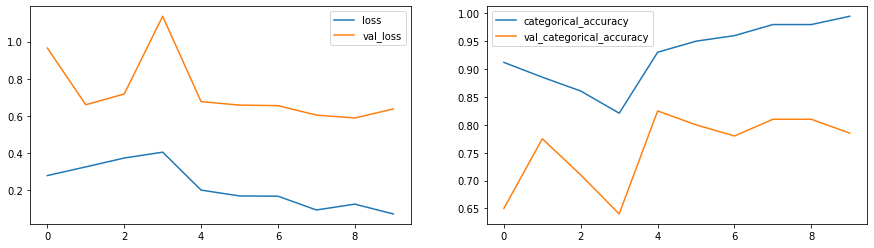

In [33]:
plot(history)

### Findings:
- With batch size 20 and no of epochs 20 model is overfitted.
- Training Accuracy: 99.50%
- validation accuracy: 78.50%
- Training loss: 0.0728 
- validation loss : 0.6370



## Model 3 with architecture of Model 1
- Increased the batch_size to 30.
- A larger batch size will give us better gradient and helps to prevent jumping around.
- No of parameters to train remains same 

In [53]:
batch_size=30
epochs =10

In [54]:
train_generator = modified_generator(train_path,train_doc,batch_size)
val_generator = modified_generator(val_path,val_doc,batch_size)

In [55]:
history2_2 = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 30
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 0.0560 - categorical_accuracy: 0.9937Source path =  /content/Project_data/val ; batch size = 30
Batch:  4 Index: 30
67/67 [==============================] - 231s 3s/step - loss: 0.0560 - categorical_accuracy: 0.9937 - val_loss: 0.5283 - val_categorical_accuracy: 0.8125

Epoch 00001: val_loss improved from 0.57707 to 0.52825, saving model to model_init_2021-05-2812_20_50.375850/model-00001-0.05601-0.99371-0.52825-0.81250.h5
Epoch 2/10
67/67 [==============================] - 85s 1s/step - loss: 0.0871 - categorical_accuracy: 0.9851 - val_loss: 0.6980 - val_categorical_accuracy: 0.7300

Epoch 00002: val_loss did not improve from 0.52825
Epoch 3/10
67/67 [==============================] - 76s 1s/step - loss: 0.0708 - categorical_accuracy: 0.9950 - val_loss: 0.4978 - val_categorical_accuracy: 0.8400

Epoch 00003: val_loss improved from 0.52825 to 0.49782, saving 

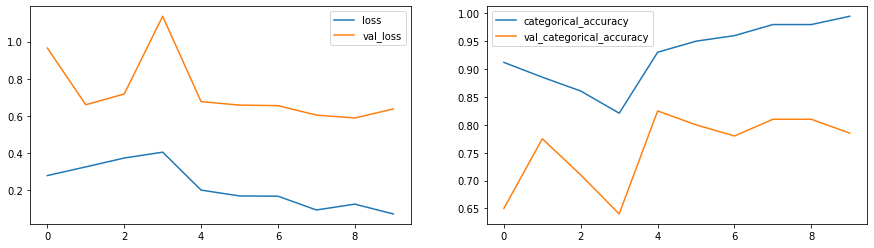

In [57]:
plot(history2_2)

### Findings:
- Training Accuracy: 100%
- validation accuracy: 79.00%
- Training loss: 0.0315  
- validation loss : 0.5512 
- The model is overfitted

## Model 4 : with batch size 64 and epoch 10

In [66]:
batch_size=64
epochs =10

In [67]:

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [68]:
train_generator = modified_generator(train_path,train_doc,batch_size)
val_generator = modified_generator(val_path,val_doc,batch_size)

In [69]:
history2_3 = model_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/10
11/11 [==============================] - 209s 21s/step - loss: 0.0147 - categorical_accuracy: 1.0000 - val_loss: 0.5997 - val_categorical_accuracy: 0.7600

Epoch 00001: val_loss did not improve from 0.47126
Epoch 2/10
11/11 [==============================] - 109s 11s/step - loss: 0.0170 - categorical_accuracy: 1.0000 - val_loss: 0.6381 - val_categorical_accuracy: 0.7800

Epoch 00002: val_loss did not improve from 0.47126
Epoch 3/10
11/11 [==============================] - 122s 12s/step - loss: 0.0144 - categorical_accuracy: 1.0000 - val_loss: 0.6041 - val_categorical_accuracy: 0.7800

Epoch 00003: val_loss did not improve from 0.47126

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 4/10
11/11 [==============================] - 113s 11s/step - loss: 0.0134 - categorical_accuracy: 1.0000 - val_loss: 0.5391 - val_categorical_accuracy: 0.8000

Epoch 00004: val_loss did not improv

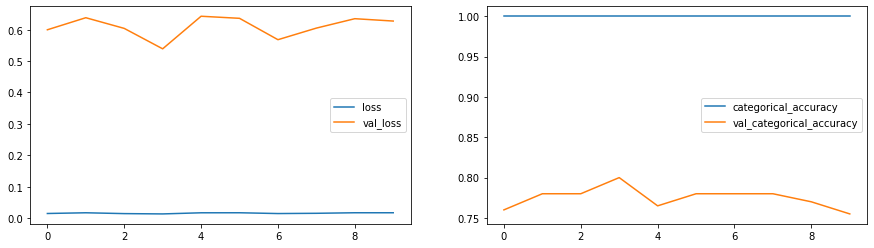

In [70]:
plot(history2_3)

## Model 5
### Filter size (3,3,3),Image size (120,120),batch size =30,No of epoch =15

In [34]:
batch_size = 30
num_epochs=10

In [35]:
x=30
y=60
z=60


In [41]:
model_2 = Sequential()

model_2.add((Conv3D(32,kernel_size=(3,3,3),input_shape=(x,y,z,3),padding="same")))
model_2.add(Activation("relu"))
model_2.add((Conv3D(32,kernel_size=(3,3,3),padding="same")))
model_2.add(Activation("relu"))
model_2.add(MaxPooling3D(pool_size=(3,3,3),padding="same"))
model_2.add(Dropout(0.25))

model_2.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model_2.add(Activation("relu"))
model_2.add((Conv3D(64,kernel_size=(3,3,3),padding="same")))
model_2.add(Activation("relu"))
model_2.add(MaxPooling3D(pool_size=(3,3,3),padding="same"))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
# model_2.add(Dense(512,activation="relu"))
# model_2.add(Dropout(0.5))

model_2.add(Dense(classes,activation="softmax"))

model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 60, 60, 32)    2624      
_________________________________________________________________
activation_16 (Activation)   (None, 30, 60, 60, 32)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 30, 60, 60, 32)    27680     
_________________________________________________________________
activation_17 (Activation)   (None, 30, 60, 60, 32)    0         
_________________________________________________________________
max_pooling3d_14 (MaxPooling (None, 10, 20, 20, 32)    0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 10, 20, 20, 32)    0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 10, 20, 20, 64)   

In [37]:
batch_size

30

In [42]:
optimiser = optimizers.Adam()
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [43]:
train_generator = modified_generator(train_path,train_doc,batch_size)
val_generator = modified_generator(val_path,val_doc,batch_size)

In [ ]:
# steps_per_epoch, validation_steps=  get_steps_per_epoch(batch_size)

Steps per Epoch on Tranining:23
Steps per Epoch on Validation:4


In [44]:
history2 = model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 30
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 1.5852 - categorical_accuracy: 0.2227Source path =  /content/Project_data/val ; batch size = 30
Batch:  4 Index: 30
67/67 [==============================] - 238s 4s/step - loss: 1.5852 - categorical_accuracy: 0.2228 - val_loss: 1.6105 - val_categorical_accuracy: 0.1562

Epoch 00001: val_loss did not improve from 0.57707
Epoch 2/10
67/67 [==============================] - 74s 1s/step - loss: 1.5854 - categorical_accuracy: 0.2299 - val_loss: 1.5240 - val_categorical_accuracy: 0.3400

Epoch 00002: val_loss did not improve from 0.57707
Epoch 3/10
67/67 [==============================] - 78s 1s/step - loss: 1.4264 - categorical_accuracy: 0.3959 - val_loss: 1.3539 - val_categorical_accuracy: 0.3800

Epoch 00003: val_loss did not improve from 0.57707
Epoch 4/10
67/67 [==============================] - 86s 1s/step - loss: 1.3519 - categorical_accuracy: 0.4058 - val_l

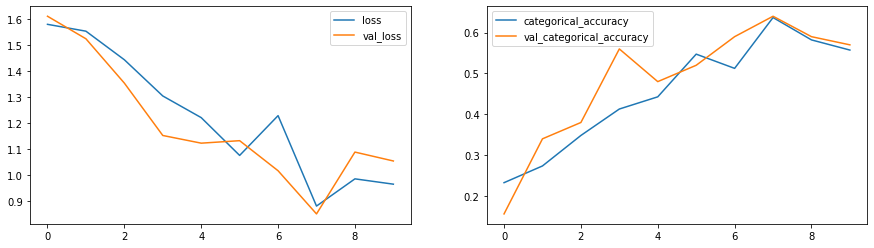

In [45]:
plot(history2)

### Findings:
- Model did not perform well with image size(60,60) with epoch 10 and batch size 30
- We will stick to image size (120,120)
- image size (160,160) is quite big with the existing infrastructure with colab.

## Model 6: Try to increases the complexity of the model:
-  Filter size (2,2,2),
- Image size (120,120),
- batch size =30, 
- No of epoch =10

In [101]:
num_epochs = 10
batch_size=10

x =30
y=120
z=120


In [102]:
model_3 = Sequential()

model_3.add(Conv3D(16,kernel_size=(2,2,2),input_shape=(x,y,z,3),padding="same"))
model_3.add(Activation("relu"))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(32,kernel_size=(2,2,2),padding="same"))
model_3.add(Activation("relu"))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(64,kernel_size=(2,2,2),input_shape=(x,y,z,3),padding="same"))
model_3.add(Activation("relu"))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Conv3D(128,kernel_size=(2,2,2),input_shape=(x,y,z,3),padding="same"))
model_3.add(Activation("relu"))
model_3.add(BatchNormalization())
model_3.add(MaxPooling3D(pool_size=(2,2,2)))

model_3.add(Flatten())
model_3.add(Dense(128,activation="relu"))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.25))

model_3.add(Dense(128,activation="relu"))
model_3.add(BatchNormalization())
model_3.add(Dropout(0.25))

model_3.add(Dense(classes,activation="softmax"))

In [103]:
model_3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_38 (Conv3D)           (None, 30, 120, 120, 16)  400       
_________________________________________________________________
activation_38 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_34 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_39 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_39 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 15, 60, 60, 32)  

In [104]:
optimiser = optimizers.Adam()
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [105]:
train_generator = generator(train_path,train_doc,10)
val_generator = generator(val_path,val_doc,10)

In [106]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [98]:
# steps_per_epoch, validation_steps=  get_steps_per_epoch(batch_size)

In [107]:
history3 = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - 182s 3s/step - loss: 1.6594 - categorical_accuracy: 0.3815 - val_loss: 3.9618 - val_categorical_accuracy: 0.2600

Epoch 00001: val_loss did not improve from 0.47126
Epoch 2/10
67/67 [==============================] - 74s 1s/step - loss: 1.4784 - categorical_accuracy: 0.4696 - val_loss: 4.6613 - val_categorical_accuracy: 0.1600

Epoch 00002: val_loss did not improve from 0.47126
Epoch 3/10
67/67 [==============================] - 78s 1s/step - loss: 1.6854 - categorical_accuracy: 0.3961 - val_loss: 3.6800 - val_categorical_accuracy: 0.2500

Epoch 00003: val_loss did not improve from 0.47126
Epoch 4/10
67/67 [==============================] - 73s 1s/step - loss: 1.5571 - categorical_accuracy: 0.3574 - val_loss: 4.0606 - val_categorical_accuracy: 0.2800

Epoch 00004: val_loss did not improve from 0.47126
Epoch 5/10
67/67 [==============================] - 77s 1s/step - loss: 1.

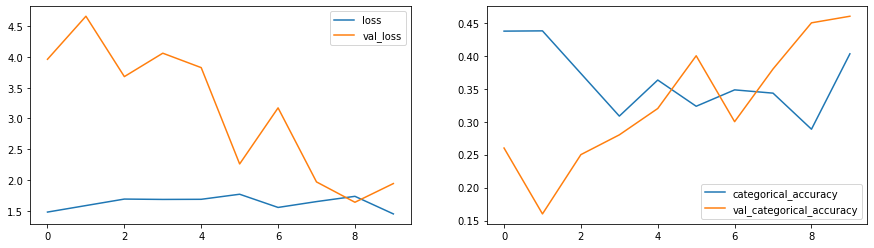

In [108]:
plot(history3)

## Model 7: Epochs=10,batch size =20

In [109]:
batch_size=20
num_epochs=10


In [112]:
train_generator = modified_generator(train_path,train_doc,batch_size)
val_generator = modified_generator(val_path,val_doc,batch_size)

In [ ]:
# steps_per_epoch, validation_steps=  get_steps_per_epoch(batch_size)

Steps per Epoch on Tranining:34
Steps per Epoch on Validation:5


In [113]:
history4 = model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/10
67/67 [==============================] - 239s 4s/step - loss: 1.3654 - categorical_accuracy: 0.4436 - val_loss: 1.4040 - val_categorical_accuracy: 0.5200

Epoch 00001: val_loss did not improve from 0.47126
Epoch 2/10
67/67 [==============================] - 109s 2s/step - loss: 1.4915 - categorical_accuracy: 0.3781 - val_loss: 1.2606 - val_categorical_accuracy: 0.5700

Epoch 00002: val_loss did not improve from 0.47126
Epoch 3/10
67/67 [==============================] - 105s 2s/step - loss: 1.5881 - categorical_accuracy: 0.3881 - val_loss: 1.4905 - val_categorical_accuracy: 0.5650

Epoch 00003: val_loss did not improve from 0.47126
Epoch 4/10
67/67 [==============================] - 109s 2s/step - loss: 1.4867 - categorical_accuracy: 0.3831 - val_loss: 1.3879 - val_categorical_accuracy: 0.4750

Epoch 00004: val_loss did not improve from 0.47126

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00025000001

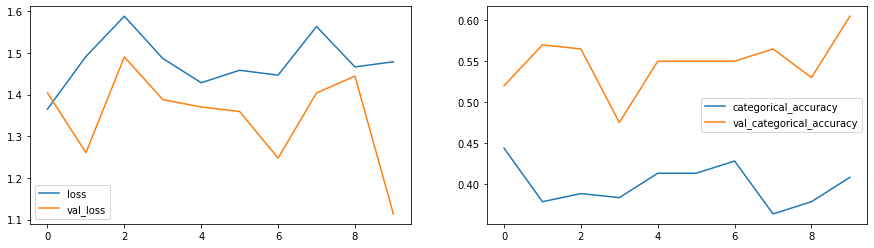

In [114]:
plot(history4)

## Model 8
### CNN LSTM


In [115]:
batch_size=40
num_epochs = 10

x=30
y=120
z=120

In [119]:
model_4 = Sequential()

model_4.add(TimeDistributed(Conv2D(16,(3,3),activation="relu",padding="same"),input_shape =(x,y,z,3)))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_4.add(TimeDistributed(BatchNormalization()))
model_4.add(TimeDistributed(MaxPooling2D((2, 2))))

model_4.add(TimeDistributed(Flatten()))

model_4.add(LSTM(64))
model_4.add(Dropout(0.25))

# model_4.add(Dense(64,activation='relu'))
# model_4.add(Dropout(0.25))

model_4.add(Dense(classes, activation='softmax'))

model_4.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_38 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_39 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_40 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_41 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 30, 30, 30, 64)  

In [123]:
optimiser = optimizers.Adam()
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [124]:
train_generator = generator(train_path,train_doc,40)
val_generator = generator(val_path,val_doc,40)

In [125]:
steps_per_epoch, validation_steps=  get_steps_per_epoch(batch_size)

Steps per Epoch on Tranining:17
Steps per Epoch on Validation:3


In [126]:
history4 = model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 40
Epoch 1/10
17/17 [==============================] - 213s 13s/step - loss: 0.8994 - categorical_accuracy: 0.6639 - val_loss: 2.4917 - val_categorical_accuracy: 0.2450

Epoch 00001: val_loss did not improve from 0.47126
Epoch 2/10
17/17 [==============================] - 147s 9s/step - loss: 0.8136 - categorical_accuracy: 0.7019 - val_loss: 2.6643 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 0.47126
Epoch 3/10
17/17 [==============================] - 142s 9s/step - loss: 0.8000 - categorical_accuracy: 0.7177 - val_loss: 2.5128 - val_categorical_accuracy: 0.2600

Epoch 00003: val_loss did not improve from 0.47126

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
17/17 [==============================] - 134s 8s/step - loss: 0.6905 - categorical_accuracy: 0.7557 - val_loss: 2.4711 - val_categorical_accuracy: 0.2350

Epoch 00004: val_loss did not improve fr

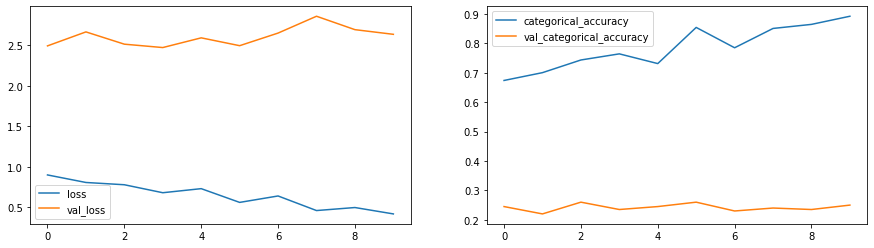

In [131]:
plot(history4)

## Model 9:

In [127]:
batch_size=64
num_epochs = 10

In [128]:
train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

In [129]:
steps_per_epoch, validation_steps=  get_steps_per_epoch(batch_size)

Steps per Epoch on Tranining:11
Steps per Epoch on Validation:2


In [130]:
history5 = model_4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  /content/Project_data/train ; batch size = 64
Epoch 1/5
11/11 [==============================] - ETA: 0s - loss: 0.4066 - categorical_accuracy: 0.8989 Source path =  /content/Project_data/val ; batch size = 64
Batch:  2 Index: 64
11/11 [==============================] - 182s 18s/step - loss: 0.4066 - categorical_accuracy: 0.8989 - val_loss: 2.6355 - val_categorical_accuracy: 0.2500

Epoch 00001: val_loss did not improve from 0.47126
Epoch 2/5
11/11 [==============================] - 79s 8s/step - loss: 0.4380 - categorical_accuracy: 0.8735 - val_loss: 2.2006 - val_categorical_accuracy: 0.4062

Epoch 00002: val_loss did not improve from 0.47126
Epoch 3/5
11/11 [==============================] - 77s 8s/step - loss: 0.3934 - categorical_accuracy: 0.9012 - val_loss: 2.3159 - val_categorical_accuracy: 0.3214

Epoch 00003: val_loss did not improve from 0.47126
Epoch 4/5
11/11 [==============================] - 64s 6s/step - loss: 0.4203 - categorical_accuracy: 0.8841 - val_los

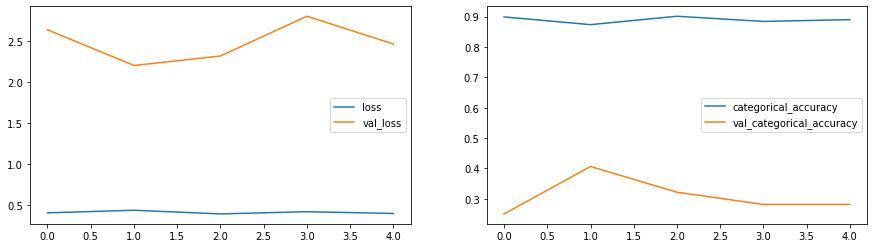

In [132]:
plot(history5)

## Model 10 : with GRU layer

In [145]:
batch_size=20
num_epochs = 10

In [146]:
model_5 = Sequential()

model_5.add(TimeDistributed(Conv2D(16,(3,3),activation="relu",padding="same"),input_shape =(x,y,z,3)))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_5.add(TimeDistributed(BatchNormalization()))
model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

# model_5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
# model_5.add(TimeDistributed(BatchNormalization()))
# model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

# model_5.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
# model_5.add(TimeDistributed(BatchNormalization()))
# model_5.add(TimeDistributed(MaxPooling2D((2, 2))))

model_5.add(TimeDistributed(Flatten()))

model_5.add(GRU(64))
# model_5.add(Dropout(0.25))

# model_5.add(Dense(64,activation='relu'))
# model_5.add(Dropout(0.25))

model_5.add(Dense(classes, activation='softmax'))

model_5.summary()


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_75 (TimeDis (None, 30, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_76 (TimeDis (None, 30, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_77 (TimeDis (None, 30, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_78 (TimeDis (None, 30, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_79 (TimeDis (None, 30, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_80 (TimeDis (None, 30, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_81 (TimeDis (None, 30, 28800)       

In [147]:
optimiser = optimizers.Adam()
model_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [148]:
steps_per_epoch, validation_steps=  get_steps_per_epoch(batch_size)

Steps per Epoch on Tranining:34
Steps per Epoch on Validation:5


In [149]:
train_generator = modified_generator(train_path,train_doc,batch_size)
val_generator =  modified_generator(val_path,val_doc,batch_size)

In [150]:
history6 = model_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - 177s 5s/step - loss: 1.9647 - categorical_accuracy: 0.3084 - val_loss: 1.9153 - val_categorical_accuracy: 0.4000

Epoch 00001: val_loss did not improve from 0.47126
Epoch 2/10
34/34 [==============================] - 51s 2s/step - loss: 1.3246 - categorical_accuracy: 0.5225 - val_loss: 2.1869 - val_categorical_accuracy: 0.3600

Epoch 00002: val_loss did not improve from 0.47126
Epoch 3/10
34/34 [==============================] - 57s 2s/step - loss: 1.3710 - categorical_accuracy: 0.4693 - val_loss: 1.6615 - val_categorical_accuracy: 0.3800

Epoch 00003: val_loss did not improve from 0.47126
Epoch 4/10
34/34 [==============================] - 49s 1s/step - loss: 1.3781 - categorical_accuracy: 0.4435 - val_loss: 2.2795 - val_categorical_accuracy: 0.2000

Epoch 00004: val_loss did not improve from 0.47126
Epoch 5/10
34/34 [==============================] - 51s 2s/step - loss: 1.

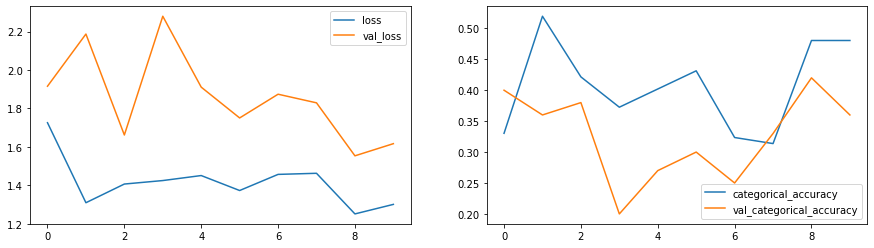

In [151]:
plot(history6)

### Findings:
- Conv2D with GRU has training accuracy 47% and validation accuracy 36%
- Training loss remains as 1.26, the validation loss remains as 1.61
- This architecture did not perform well.

## Final Model

 - Final model I have taken as Model 2 which was conv3D 
 - It had training accuracy 99% and validation accuracy 78%. 
 

In [50]:
batch_size = 20 
num_epochs=10


final_model = Sequential()

final_model.add(Conv3D(8, #number of filters 
                 kernel_size=(2,2,2), 
                 input_shape=(30, 120, 120, 3),
                 padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))

final_model.add(MaxPooling3D(pool_size=(2,2,2)))

final_model.add(Conv3D(16, #Number of filters, 
                 kernel_size=(2,2,2), 
                 padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))

final_model.add(MaxPooling3D(pool_size=(2,2,2)))


final_model.add(Conv3D(32, #Number of filters 
                 kernel_size=(2,2,2), 
                 padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))

final_model.add(MaxPooling3D(pool_size=(2,2,2)))

final_model.add(Conv3D(64, 
                 kernel_size=(3,3,3), 
                 padding='same'))
final_model.add(BatchNormalization())
final_model.add(Activation('relu'))

final_model.add(MaxPooling3D(pool_size=(2,2,2)))



#Flatten Layers
final_model.add(Flatten())


#softmax layer
final_model.add(Dense(5, activation='softmax'))


In [51]:
optimiser = optimizers.Adam() #write your optimizer
final_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy']) #Compile the model
print (final_model.summary()) #Check

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_14 (Conv3D)           (None, 30, 120, 120, 8)   200       
_________________________________________________________________
batch_normalization_12 (Batc (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_12 (Activation)   (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 60, 60, 8)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 15, 60, 60, 16)    1040      
_________________________________________________________________
batch_normalization_13 (Batc (None, 15, 60, 60, 16)    64        
_________________________________________________________________
activation_13 (Activation)   (None, 15, 60, 60, 16)   

In [54]:

train_generator = generator(train_path,train_doc,batch_size)
val_generator = generator(val_path,val_doc,batch_size)

In [55]:
history = final_model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/Project_data/train ; batch size = 20
Epoch 1/10
34/34 [==============================] - 175s 5s/step - loss: 0.5823 - categorical_accuracy: 0.7994 - val_loss: 1.0588 - val_categorical_accuracy: 0.5600

Epoch 00001: val_loss improved from 1.48227 to 1.05880, saving model to model_init_2021-05-2900_52_53.166531/model-00001-0.58230-0.79940-1.05880-0.56000.h5
Epoch 2/10
34/34 [==============================] - 55s 2s/step - loss: 0.6932 - categorical_accuracy: 0.8137 - val_loss: 0.8755 - val_categorical_accuracy: 0.6200

Epoch 00002: val_loss improved from 1.05880 to 0.87546, saving model to model_init_2021-05-2900_52_53.166531/model-00002-0.69321-0.81373-0.87546-0.62000.h5
Epoch 3/10
34/34 [==============================] - 55s 2s/step - loss: 0.6597 - categorical_accuracy: 0.7941 - val_loss: 0.8543 - val_categorical_accuracy: 0.7200

Epoch 00003: val_loss improved from 0.87546 to 0.85425, saving model to model_init_2021-05-2900_52_53.166531/model-00003-0.65973-0.

#### The final model saved as to
#### model_init_2021-05-2900_52_53.166531/model-00010-0.47066-0.84314-0.59097-0.83000.h5 

### Conclusion :-
- Therr is a tradeoff between model accuracy/performance and No of paramters .
- The number of operations(FLOPS) in a network model can effectively estimate inference time.
- With 80,000 paramters and Convolution 3D model having shallow layer ,gives aproximately 84% in Training set and 
  83% accuracy in validation set.
- To get around same accuracy,with combination of CONV2D and RNN required heavy model and more no of parameters to be trained.
- Hence to choose a right model is always problem dependant i:e in What kind of scenario we are planning to use.
- Model architecture,peformance and serving in production environment requires rigorous testing in all phases of life cycle.